In [ ]:
#The efficientnet containes silu activation functions, which are not supported my may quantization t
# tools as well as by many hardware implementation libraries doesnot support Swish activation fucnction
#We will be going to replace all those SILU layers with Swish and evaluate the model performance

#I will be using efficienet-v2 pretrained and refined on CIFAR-10 Dataset

In [60]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import os
import random
# import torch.nn.Functional as F

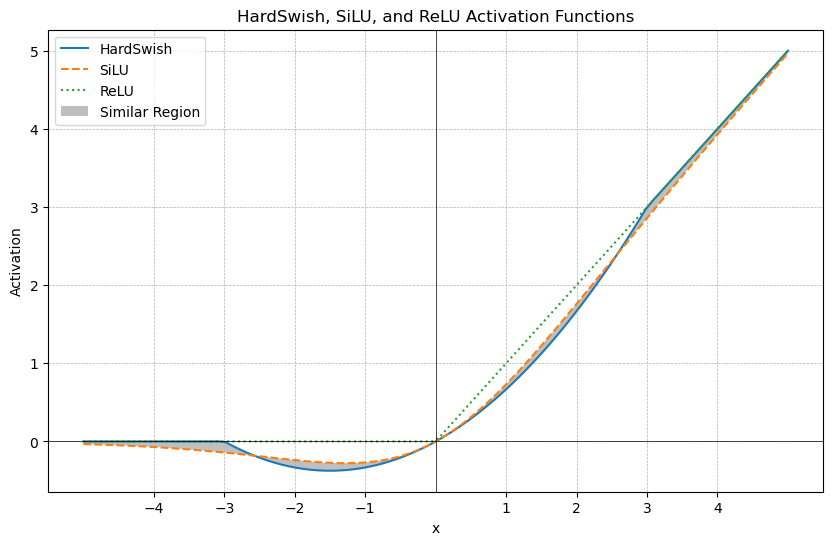

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def hard_swish(x):
    return x * np.clip((x + 3.0) / 6.0, 0, 1)

def silu(x):
    return x * (1.0 / (1.0 + np.exp(-x)))

def relu(x):
    return np.maximum(0, x)

# Generate input values from -5 to 5
x = np.linspace(-5, 5, 100)

# Compute the output of the HardSwish function
hard_swish_output = hard_swish(x)

# Compute the output of the SiLU function
silu_output = silu(x)

# Compute the output of the ReLU function
relu_output = relu(x)

# Plot the functions
plt.figure(figsize=(10, 6))
plt.plot(x, hard_swish_output, label='HardSwish', linestyle='-')
plt.plot(x, silu_output, label='SiLU', linestyle='--')
plt.plot(x, relu_output, label='ReLU', linestyle=':')

plt.xlabel('x')
plt.ylabel('Activation')
plt.title('HardSwish, SiLU, and ReLU Activation Functions')
plt.legend()
plt.grid( linestyle = '--', linewidth = 0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)


# Highlight the region where HardSwish and SiLU are similar
similar_region = np.abs(hard_swish_output - silu_output) <= 0.2
plt.fill_between(x, hard_swish_output, silu_output, where=similar_region,
                 facecolor='gray', alpha=0.5, label='Similar Region')

plt.legend(loc='upper left')
plt.xticks([-4,-3,-2,-1,1,2,3,4])
plt.show()


The highlighted region demonstrates that both the HardSwish and SiLU activation functions are similar, with almost identical behavior in the range where their outputs are nonzero. The similarity between HardSwish and SiLU in this region is a characteristic that allows HardSwish to be a computationally efficient approximation of SiLU while maintaining good performance in deep learning models.

Computational Efficiency: The HardSwish activation function is computationally more efficient than SiLU because it avoids the expensive exponential operation present in the SiLU function. Instead, HardSwish utilizes simple arithmetic operations (addition, multiplication, and clipping), which are more lightweight and can lead to faster inference on low-resource devices.

Memory Efficiency: The HardSwish activation function uses fewer memory resources compared to SiLU since it requires only basic arithmetic and does not involve storing and recalling intermediate values from the exponential function.

Similar Performance: HardSwish is designed to closely approximate SiLU in terms of its shape and behavior, especially in the region where both functions are nonzero. Research has shown that the performance difference between HardSwish and SiLU is minimal in many scenarios, making it a suitable replacement for resource-constrained devices.

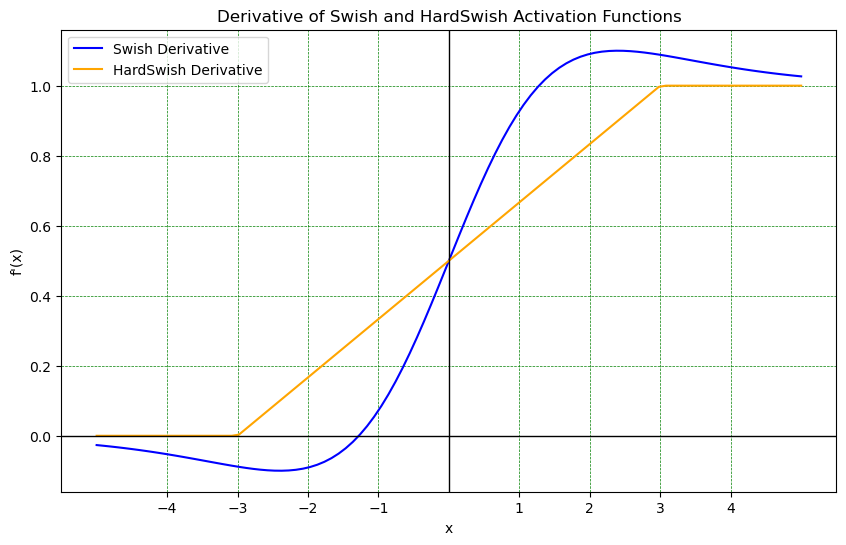

In [57]:
def swish(x):
    return x * sigmoid(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def swish_derivative(x):
    return swish(x) + sigmoid(x) * (1 - swish(x))

def hardswish(x):
  return x * np.clip((x + 3.0) / 6.0, 0, 1)

def hardswish_derivative(x):
    return np.where(x < -3, 0, np.where(x > 3, 1, (x + 3.0) / 6.0))

# Visualization
x = np.linspace(-5, 5, 100)
swish_derivative_values = swish_derivative(x)
hardswish_derivative_values = hardswish_derivative(x)
plt.figure(figsize=(10,6))
plt.plot(x, swish_derivative_values, label='Swish Derivative', color='blue')
plt.plot(x, hardswish_derivative_values, label='HardSwish Derivative', color='orange')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.xlabel('x')
plt.ylabel('f\'(x)')
plt.xticks([-4,-3,-2,-1,1,2,3,4])
plt.title('Derivative of Swish and HardSwish Activation Functions')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()


In [ ]:
#visualization of their derivatives
import numpy as np
import matplotlib.pyplot as plt

def swish(x):
    return x * sigmoid(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def swish_derivative(x):
    return swish(x) + sigmoid(x) * (1 - swish(x))

def hardswish(x):
    return x * np.clip(x + 3, 0, 6) / 6

def hardswish_derivative(x):
    return np.clip((x > -3) & (x < 3), 0, 1) / 6

# Visualization
x = np.linspace(-5, 5, 100)
swish_derivative_values = swish_derivative(x)
hardswish_derivative_values = hardswish_derivative(x)

plt.plot(x, swish_derivative_values, label='Swish Derivative', color='blue')
plt.plot(x, hardswish_derivative_values, label='HardSwish Derivative', color='orange')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('f\'(x)')
plt.title('Derivative of Swish and HardSwish Activation Functions')
plt.grid(True)
plt.show()


In [29]:
model = torch.load('/kaggle/input/pruning-effficientnet-v2-s-on-cifar10/81%_sparse_model.pt')
#This is pruned pretrained model with mask

In [30]:
#original accuracy 
acc, loss= evaluate_model(model)

100%|██████████| 313/313 [00:32<00:00,  9.50it/s]

Evaluation Loss: 0.1048 Acc: 0.9759


In [31]:
i=0
def replace_layer(m):
    global i 
    for name, child in m.named_children():
        if len(list(child.children()))> 0:
            replace_layer(child)
        
        elif isinstance(child, nn.SiLU):
            setattr(m, name, nn.Hardswish(inplace=True))
            i=i+1

replace_layer(model)
print(f'{i} SiLU layers replaced with hard-swish layers')

102 SiLU layers replaced with hard-swish layers


In [32]:
#checking if there is anu SiLU left
for module in model.modules():
    if isinstance(module, nn.SiLU):
        what=True
    else: 
        what = False

print('SiLU Layers: ', what)
    

SiLU Layers:  False


# Evaluating accuracy

In [33]:
#accuracy of replaced model 
acc, loss= evaluate_model(model)

100%|██████████| 313/313 [00:33<00:00,  9.48it/s]

Evaluation Loss: 1.1193 Acc: 0.6270


In [ ]:
# #dataset
# trans = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
# ])

# test_data = torchvision.datasets.CIFAR10(root='/kaggle/working/', train=False, download = True, transform = trans)

# test_set = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            

## Model Retraining, the model was intialy pruned 81%, and then the silu layers were replaced.


In [42]:
#all funcs
import torch.nn.utils.prune as prune

def pruning(model, amt=0.4, method= prune.L1Unstructured):
    parameters_to_prune = [
        (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules())
    ]


    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=method,
        amount=amt,
    )
    
    print('Completed Pruning.........')
    return model

#Removes the mask and applies pruning permanently 
def remove_mask(model):
    for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules()):
        prune.remove(module, 'weight')
    
#calculate the sparsity in the model
def cal_sparsity(model):
    z=0
    para= 0
    for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules()):
        para+= module.weight.numel() 
        z+= torch.sum(module.weight==0)
    sparsity = z/para
    print(f'sparisty: {sparsity*100}% \nZero_Wt: {z}\nTotal Params: {para}')
    return sparsity, z, para
    

This aplies the mask with 81% pruning but, the model we loaded already had mask with 81% pruned weights

In [34]:
# model = pruning(model, amt=0.81)
# loss, acc = evaluate_model(model)
# print(loss, acc)


In [38]:
#check for mask 
print(module._forward_pre_hooks)
#print(list(model.named_buffers())), print the mask

OrderedDict()


In [43]:
#Verifying sparsity

sparsity, z, para= cal_sparsity(model)

sparisty: 81.18399047851562% 
Zero_Wt: 16227402
Total Params: 19988424


In [44]:
# Evaluating model 
acc, loss= evaluate_model(model)

100%|██████████| 313/313 [00:32<00:00,  9.51it/s]

Evaluation Loss: 1.1193 Acc: 0.6270


# Retraining


Dataset preperation, for training and evaluation

In [45]:
#All the necessary code to load and configure the dataset 

batch_size = 32
path = '/kaggle/working/'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


trainset = torchvision.datasets.CIFAR10(root=path, 
                                        train=True, download=False, 
                                        transform=data_transforms['train'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


testset = torchvision.datasets.CIFAR10(root=path, 
                                        train=False, download=False, 
                                        transform=data_transforms['test'])

                                     
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



#Making things easy, so storing it in a dictionary 
dataset_size = [len(trainset), len(testset)]
dataloaders= {
    "train": trainloader,
    "val": testloader
}
dataset_sizes = {
    "train": dataset_size[0],
    "val": dataset_size[1]
}

class_names = trainset.classes

In [46]:

#Function for training the model, forware prop and backward prop 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #storing epoch data
    epoch_data =     {
        'epoch': [],
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': [] }
    }
    
    # Create a temporary directory in Kaggle's temp directory
    tempdir = '/kaggle/working/temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        epoch_data['epoch'].append(epoch+1)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            

            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_data[phase]['loss'].append(epoch_loss)
            epoch_data[phase]['acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    # Clean up the temporary directory
    shutil.rmtree(tempdir)

    return model, epoch_data


#Evaluating the model performance on the test set
def evaluate_model(model, criterion = nn.CrossEntropyLoss() , dataloader = testloader ):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(dataloader.dataset)
    eval_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Evaluation Loss: {eval_loss:.4f} Acc: {eval_acc:.4f}')

    return eval_loss, eval_acc




NameError: name 'epoch_data' is not defined

In [47]:

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [48]:
model_ft, epoch_data = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 1/20
----------


train Loss: 0.0755 Acc: 0.9757


val Loss: 0.1106 Acc: 0.9699

Epoch 2/20
----------


train Loss: 0.0515 Acc: 0.9826


val Loss: 0.1095 Acc: 0.9726

Epoch 3/20
----------


train Loss: 0.0403 Acc: 0.9862


val Loss: 0.1067 Acc: 0.9727

Epoch 4/20
----------


train Loss: 0.0345 Acc: 0.9886


val Loss: 0.1025 Acc: 0.9733

Epoch 5/20
----------


train Loss: 0.0324 Acc: 0.9897


val Loss: 0.1049 Acc: 0.9742

Epoch 6/20
----------


train Loss: 0.0267 Acc: 0.9912


val Loss: 0.1054 Acc: 0.9738

Epoch 7/20
----------


train Loss: 0.0247 Acc: 0.9918


val Loss: 0.1034 Acc: 0.9750

Epoch 8/20
----------


train Loss: 0.0202 Acc: 0.9936


val Loss: 0.1008 Acc: 0.9753

Epoch 9/20
----------


train Loss: 0.0185 Acc: 0.9942


val Loss: 0.1002 Acc: 0.9756

Epoch 10/20
----------


train Loss: 0.0173 Acc: 0.9947


val Loss: 0.0997 Acc: 0.9763

Epoch 11/20
----------


train Loss: 0.0178 Acc: 0.9942


val Loss: 0.1020 Acc: 0.9765

Epoch 12/20
----------


train Loss: 0.0172 Acc: 0.9945


val Loss: 0.1013 Acc: 0.9754

Epoch 13/20
----------


train Loss: 0.0174 Acc: 0.9948


val Loss: 0.1023 Acc: 0.9756

Epoch 14/20
----------


train Loss: 0.0163 Acc: 0.9949


val Loss: 0.1011 Acc: 0.9759

Epoch 15/20
----------


train Loss: 0.0163 Acc: 0.9951


val Loss: 0.0996 Acc: 0.9763

Epoch 16/20
----------


train Loss: 0.0163 Acc: 0.9947


val Loss: 0.1009 Acc: 0.9768

Epoch 17/20
----------


train Loss: 0.0155 Acc: 0.9954


val Loss: 0.1008 Acc: 0.9763

Epoch 18/20
----------


train Loss: 0.0167 Acc: 0.9946


val Loss: 0.1016 Acc: 0.9769

Epoch 19/20
----------


train Loss: 0.0160 Acc: 0.9950


val Loss: 0.1008 Acc: 0.9754

Epoch 20/20
----------


train Loss: 0.0160 Acc: 0.9951


val Loss: 0.1011 Acc: 0.9768

Training complete in 152m 26s
Best val Acc: 0.976900


NameError: name 'shutil' is not defined

!oh missded to import shutil

In [51]:
#Loading best model 
model.load_state_dict(torch.load('/kaggle/working/temp/best_model_params.pt'))

#reconstructing epoch data

In [58]:
epoch_data = {
    'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'train': {'loss': [0.0755, 0.0515, 0.0403, 0.0345, 0.0324, 0.0267, 0.0247, 0.0202, 0.0185, 0.0173, 0.0178, 0.0172, 0.0174, 0.0163, 0.0163, 0.0163, 0.0155, 0.0167, 0.0160, 0.0160],
              'acc': [0.9757, 0.9826, 0.9862, 0.9886, 0.9897, 0.9912, 0.9918, 0.9936, 0.9942, 0.9947, 0.9942, 0.9945, 0.9948, 0.9949, 0.9951, 0.9947, 0.9954, 0.9946, 0.9950, 0.9951]},
    'val': {'loss': [0.1106, 0.1095, 0.1067, 0.1025, 0.1049, 0.1054, 0.1034, 0.1008, 0.1002, 0.0997, 0.1020, 0.1013, 0.1023, 0.1011, 0.0996, 0.1009, 0.1008, 0.1016, 0.1008, 0.1011],
            'acc': [0.9699, 0.9726, 0.9727, 0.9733, 0.9742, 0.9738, 0.9750, 0.9753, 0.9756, 0.9763, 0.9765, 0.9754, 0.9756, 0.9759, 0.9763, 0.9768, 0.9763, 0.9769, 0.9754, 0.9768]}
}


# Visualizing the training 

In [52]:
#Sparsity check
sparsity, z, para= cal_sparsity(model)

sparisty: 81.18399047851562% 
Zero_Wt: 16227402
Total Params: 19988424


In [54]:
path = '/kaggle/working/'
best_model = os.path.join(path, 'efficientnet-v2_replaced.pt')
torch.save(best_md, best_model)

<Figure size 640x480 with 0 Axes>

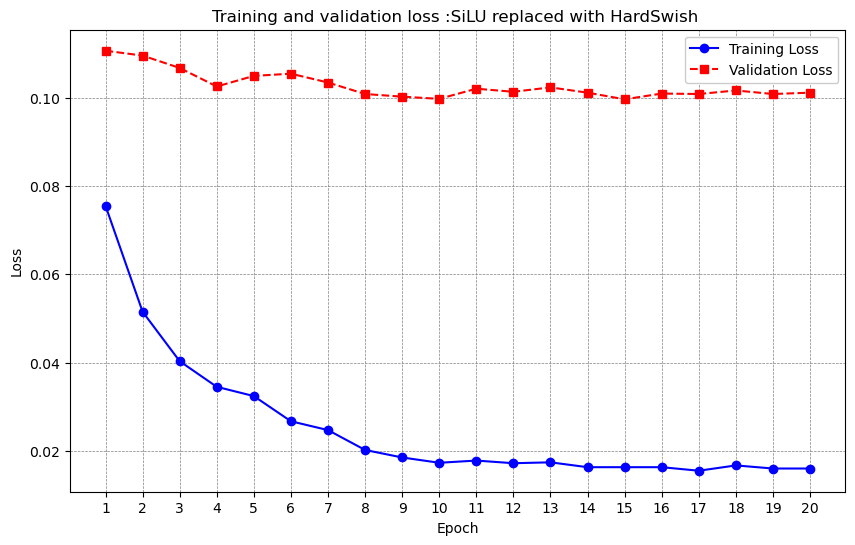

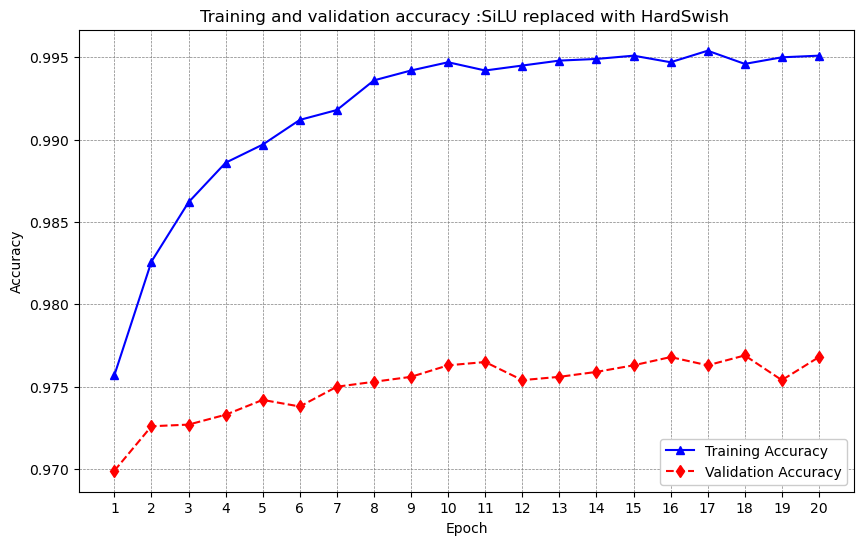

In [64]:
plot_model_train(epoch_data, title = ' :SiLU replaced with HardSwish ')

In [63]:
def plot_model_train(epoch_data, title = ' '):
    epochs = epoch_data['epoch']
    train_loss = epoch_data['train']['loss']
    val_loss = epoch_data['val']['loss']
    train_acc = epoch_data['train']['acc']
    val_acc = epoch_data['val']['acc']

    # Plotting the training and validation loss
    plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='s')
    plt.xlabel('Epoch', color='black')
    plt.ylabel('Loss', color='black')
    plt.title('Training and validation loss'+title, color='black')
    plt.legend(loc='upper right', facecolor='white', framealpha=1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xticks(range(1,21))
    plt.savefig('plot2.png')
    # Plotting the training and validation accuracy
    plt.figure(2)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='^')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--', marker='d')
    plt.xlabel('Epoch', color='black')
    plt.ylabel('Accuracy', color='black')
    plt.title('Training and validation accuracy'+title, color='black')
    plt.legend(loc='lower right', facecolor='white', framealpha=1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xticks(range(1,21))
    
    n = random.randint(0,100)
    plt.savefig(f'plot{n}.png')

    plt.show()
    



# saving the weights

In [ ]:
#removing the mask
remove_mask(model)

In [76]:
#evaluate model 
evaluate_model(model)

100%|██████████| 313/313 [00:32<00:00,  9.63it/s]

Evaluation Loss: 0.1016 Acc: 0.9769


(0.10162458331212401, tensor(0.9769, device='cuda:0', dtype=torch.float64))

In [77]:
torch.save(model.state_dict(), 'efficientnetV2.pth')
